# Conformal Survival Bands for Risk Screening under Right-Censoring

This notebook illustrates how to apply the `confsurv` package to compute **conformal survival bands** for right-censored survival data, with a focus on synthetic examples.

Conformal survival bands provide calibrated uncertainty quantification around individual survival functions. They are especially useful for **risk screening tasks**, such as identifying high-risk or low-risk individuals while controlling the rate of false positives.


Our method is model-agnostic and works with any fitted survival model. It integrates ideas from conformal inference, inverse probability of censoring weighting (IPCW), and multiple testing with false discovery rate (FDR) control.

This notebook accompanies the paper:

> **Conformal Survival Bands for Risk Screening under Right-Censoring**  
> Matteo Sesia and Vladimir Svetnik (2025)  
> [link to arXiv preprint will be added soon]

For full methodological details and theoretical analysis, please refer to the paper.

In the following sections, we walk through:
- Simulating censored survival data
- Fitting black-box survival and censoring models
- Constructing conformal survival bands
- Using bands for screening and evaluating performance

## 🔧 Setup: Load Libraries and Install `confsurv`

We begin by loading the required libraries for data handling, visualization, survival modeling, and conformal prediction.  
The `confsurv` package provides a unified interface to multiple survival models (including GRF, Cox, survreg, and random forests), along with the core implementation of the conformal inference method for censored data described in the accompanying paper.

To install the latest development version of `confsurv` from GitHub:

```r
# Uncomment and run the following if not already installed
# install.packages("devtools")
# devtools::install_github("msesia/confsurv")
```

In [1]:
# Load required libraries
suppressMessages(library(tidyverse))    # Data manipulation and visualization
suppressMessages(library(gridExtra))    # Arrange multiple ggplot objects
library(survival)                       # Survival analysis tools
library(ggsurvfit)                      # Clean survival curve plots
library(grf)                            # Generalized random forests (GRF model)

library(confsurv)                       # Custom package for conformal survival methods

# Load utility functions for generating synthetic survival data 
source("../utils/utils_synthetic_data.R")
# Load utility functions for plotting results
source("../utils/utils_plotting.R")

## Generate Synthetic Survival Data

We reproduce the synthetic data settings described in the paper. Each setting simulates right-censored survival data with a known data-generating process, allowing us to evaluate performance under controlled conditions.

The simulation functions are defined in `utils_synthetic_data.R`. You can toggle between different scenarios by changing the `setting` value:

- **Setting 1–3**: Replicate the setups from Sesia & Svetnik (2025), ordered by increasing difficulty
- **Setting 4**: New, more heterogeneous setting

In [2]:
# Choose the data generation setting
setting <- 4  # Change to 2, 3, or 4 to match paper settings

# Initialize the data generator for the chosen setting
datagen <- init_data_generator(setting)  
num_features <- datagen$num_features

# Extract functions for generating features, event times, and censoring times
covariate_generator <- datagen$covariate_generator
survival_generator <- datagen$survival_generator
censoring_generator <- datagen$censoring_generator
survival_generator_shift <- datagen$survival_generator_shift

# Initialize survival data generators
generator <- SurvivalDataGenerator$new(covariate_generator, survival_generator, censoring_generator)
generator_shift <- SurvivalDataGenerator$new(covariate_generator, survival_generator_shift, censoring_generator)

# Define sample sizes
num_samples_train <- 1000
num_samples_cal <- 500
num_samples_test <- 100

# Optional: set seed for reproducibility
set.seed(2025)

# Generate full survival datasets (X, T, C, status)
data.train.oracle <- generator$sample(num_samples_train)
data.cal.oracle <- generator$sample(num_samples_cal)
data.test.oracle <- generator$sample(num_samples_test)

# Optionally move censored calibration samples into the training set
move_censored_obs <- FALSE
if (move_censored_obs) {
    idx.cal.censored <- which(data.cal.oracle$status == 0)
    idx.cal.event <- which(data.cal.oracle$status == 1)
    if (length(idx.cal.censored) > 0) {
        data.train.oracle <- rbind(data.train.oracle, data.cal.oracle[idx.cal.censored, ])
    }
    if (length(idx.cal.event) > 0) {
        data.cal.oracle <- data.cal.oracle[idx.cal.event, ]
    } else {
        warning("Warning! No events in calibration data set.")
        data.cal.oracle <- head(data.cal.oracle, 0)
    }
}

# Construct right-censored datasets (observed times: min(T, C))
data.train <- data.train.oracle |> select(-event_time, -censoring_time)
data.cal <- data.cal.oracle |> select(-event_time, -censoring_time)
data.test <- data.test.oracle |> select(-event_time, -censoring_time)

# Print dataset summary
cat(sprintf("Generated synthetic data sets.\n"))
cat(sprintf("Training set: %d individuals, of which %d censored.\n", 
            nrow(data.train), sum(data.train$status == 0)))
cat(sprintf("Calibration set: %d individuals, of which %d censored.\n", 
            nrow(data.cal), sum(data.cal$status == 0)))

# Combine training and calibration sets (if needed for supervised learning)
data.supervised <- rbind(data.train, data.cal)

Generated synthetic data sets.
Training set: 1000 individuals, of which 389 censored.
Calibration set: 500 individuals, of which 184 censored.


## Visualize Survival Curves: Individual (oracle) vs. Population-Level (Kaplan-Meier)

To better understand the synthetic survival data, we start by visualizing both:

- **Individual true survival curves** generated directly from the known data-generating process (for 10 example patients)
- The **Kaplan–Meier (KM) estimate**, which gives a nonparametric survival curve over the entire calibration set

This comparison illustrates the difference between personalized and population-level survival estimates.

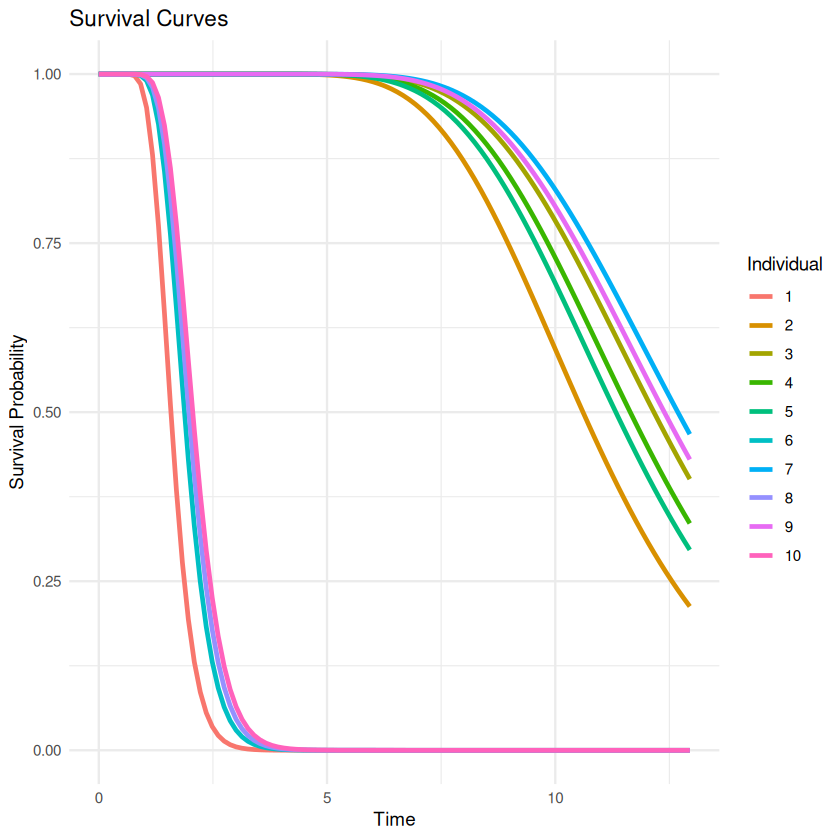

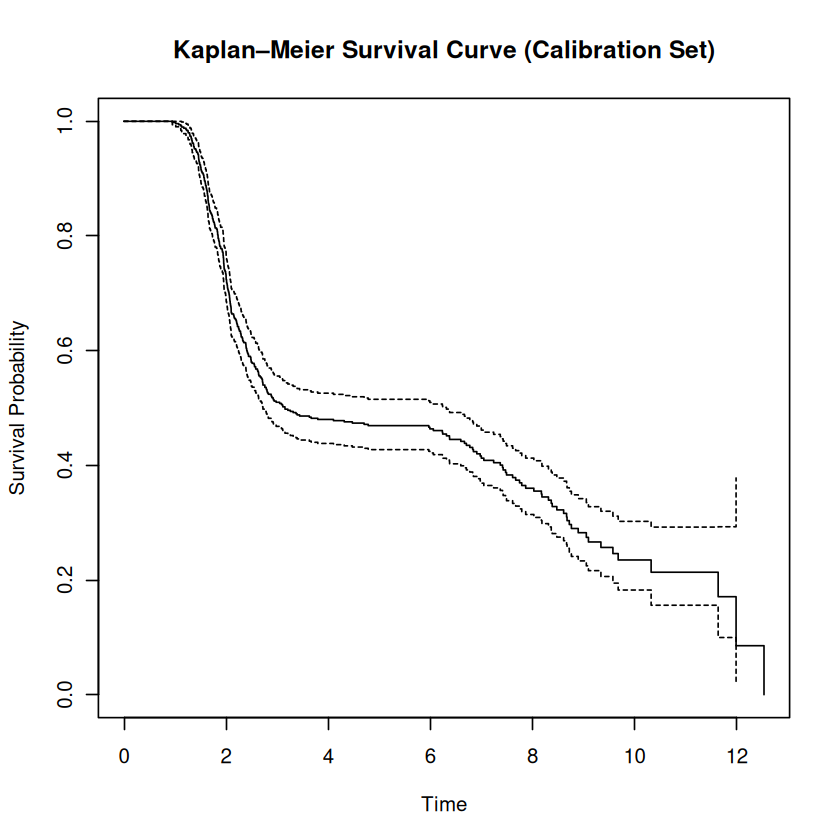

In [3]:
# --- Plot true survival curves for a few individuals ---

# Select 10 example patients from the training set
patient.list <- 1:10

# Extract their covariates (drop time and status columns)
X <- select(data.train[patient.list, ], -time, -status)

# Define a time grid for evaluating survival probabilities
time.points <- seq(0, max(data.train$time), length.out = 100)

# Use the known survival generator to get true survival probabilities
predictions <- survival_generator$predict(X, time.points)

# Plot personalized survival curves
plot_survival_curves(predictions)


# --- Plot population-level Kaplan–Meier curve ---

# Create survival object from calibration data
surv_object <- Surv(time = data.cal$time, event = data.cal$status)

# Fit KM estimator
km_fit <- survival::survfit(surv_object ~ 1)

# Plot Kaplan–Meier survival estimate
plot(km_fit, xlab = "Time", ylab = "Survival Probability", 
     main = "Kaplan–Meier Survival Curve (Calibration Set)")

## Model Fitting and Calibration for Conformal Survival Bands

This section fits the required models and computes **conformal survival bands (CSBs)** on right-censored data.

These predictive bands provide **distribution-free guarantees** and can be used for tasks like patient risk screening.

We will:

1. Fit a **survival model** to estimate personalized survival curves.
2. Fit a **censoring model** to estimate inverse probability of censoring weights (IPCW).
3. Use both models in the CSB method to compute calibrated lower and upper survival bands.

### Choose and Fit a Survival Model

Select a model type using the `model_type` string. Available options:

- `"grf"`: Generalized random forest (via the `grf` package)
- `"cox"`: Cox proportional hazards model (via the `survival` package)
- `"survreg"`: Parametric survival regression (e.g., lognormal distribution)
- `"rf"`: Random survival forest (via the `randomForestSRC` package)

These models are wrapped with a unified interface via the `SurvivalModelWrapper` class.

Each wrapper implements:
- `fit(formula, data)`
- `predict(new_data, time.points)`

This ensures compatibility with the CSB algorithm.

In [4]:
# Choose survival model type
model_type <- "grf"  # Options: "cox", "survreg", "rf", "grf"

# Initialize and fit the survival model using unified instantiator
surv_model <- init_surv_model(model_type)
surv_model$fit(Surv(time, status) ~ ., data = data.train)

### Choose and Fit a Censoring Model

We now choose and fit a model to estimate the censoring distribution, which is used for **inverse probability of censoring weighting (IPCW)**.

In this simulation, we **know that some covariates are unrelated to censoring**, so we restrict the censoring model to use only the subset of features that are believed to be relevant. This improves stability and avoids unnecessary variance. However, it's not necessary to restrict the features for the censoring model in general.

You may use the same model type as the survival model, or choose a different one.


Options:
- `"grf"`: Generalized random forest
- `"cox"`: Cox proportional hazards
- `"survreg"`: Parametric model
- `"rf"`: Random survival forest

In [5]:
# Select covariates known to be informative for censoring
num_feat_censor <- 10
use_covariates <- paste("X", 1:min(num_features, num_feat_censor), sep = "")

# Choose censoring model type (can differ from survival model)
censoring_model_type <- "grf"

# Initialize and fit the censoring model
cens_base_model <- init_censoring_model(censoring_model_type, use_covariates = use_covariates)
cens_model <- CensoringModel$new(model = cens_base_model)
cens_model$fit(data = data.train)

## Inspect Fitted Survival Model Predictions

Before constructing conformal bands, we visualize the **raw survival curves** predicted by the fitted survival model.

This allows us to check whether the model:
- Produces plausible and smooth survival estimates
- Reflects differences between patients
- Captures overall survival behavior over time

We plot survival curves for a small set of test patients below.


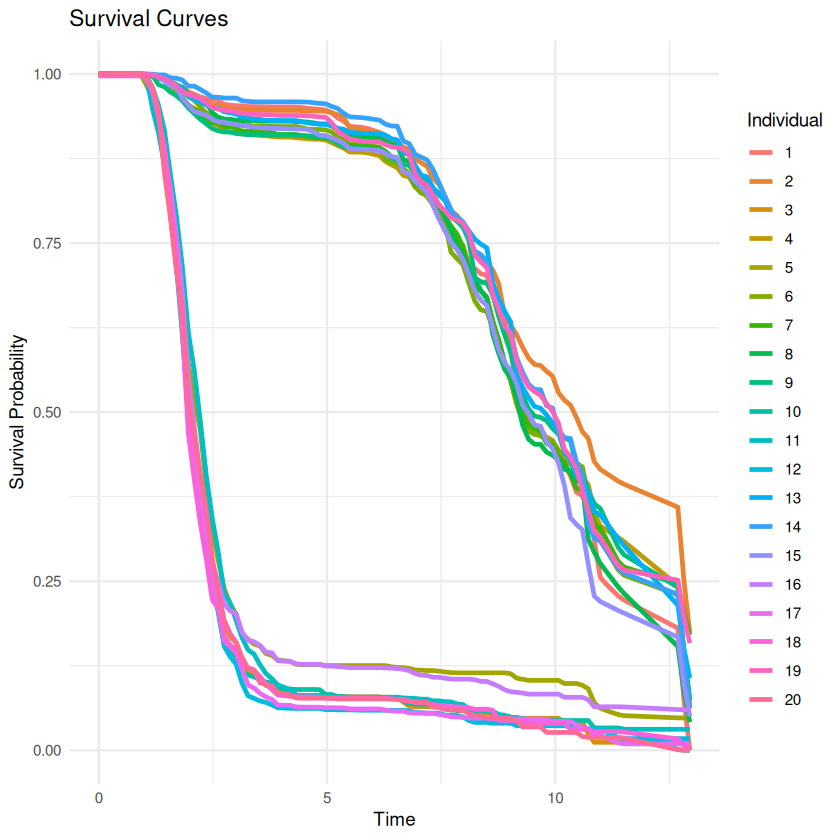

In [6]:
# Define patients to visualize
patient.list <- 1:20

# Predict survival curves for selected patients
predictions <- surv_model$predict(data.test[patient.list, ], time.points)

# Plot predicted curves
plot_survival_curves(predictions)

## 📐 Build Conformal Survival Bands

Now that both the survival and censoring models are fitted, we can construct **conformal survival bands** using the `conformal_survival_band()` function from the `confsurv` package.

This method:

- Computes conformal p-values using IPC-weighted comparisons
- Applies Benjamini–Hochberg correction for multiple testing
- Returns **calibrated lower and upper bands** around the predicted survival curves

These bands offer predictive guarantees and are useful for screening tasks such as identifying low-risk or high-risk patients.

In [7]:
# Define a time grid for prediction and band construction
time.points <- seq(0, max(data.train$time), length.out = 100)

# Run conformal calibration procedure
csb <- conformal_survival_band(
    data.test = data.test,
    data.cal = data.cal,
    surv_model = surv_model,
    cens_model = cens_model,
    time_points = time.points,
    fast = TRUE
)

### Output of `calibrate_survival()`

The result is a list containing:

- `model_pred`: predicted survival probabilities from the fitted model
- `lower`, `upper`: calibrated lower and upper bands (pointwise)

Next, we’ll visualize these bands and explore how to use them for clinical-style risk screening.

## 📈 Visualize Conformal Survival Bands for Individual Patients

We now plot conformal survival bands for a subset of patients. These bands are derived from the calibrated results and reflect uncertainty around the predicted survival probabilities.

For comparison, we also overlay the **oracle survival curves**, computed using the known data-generating model. This allows us to assess the **accuracy and coverage** of the conformal bands.

The plot shows:

- The fitted survival curve (black line)
- The calibrated lower and upper bands (shaded region)
- The true (oracle) survival curve (dashed green)


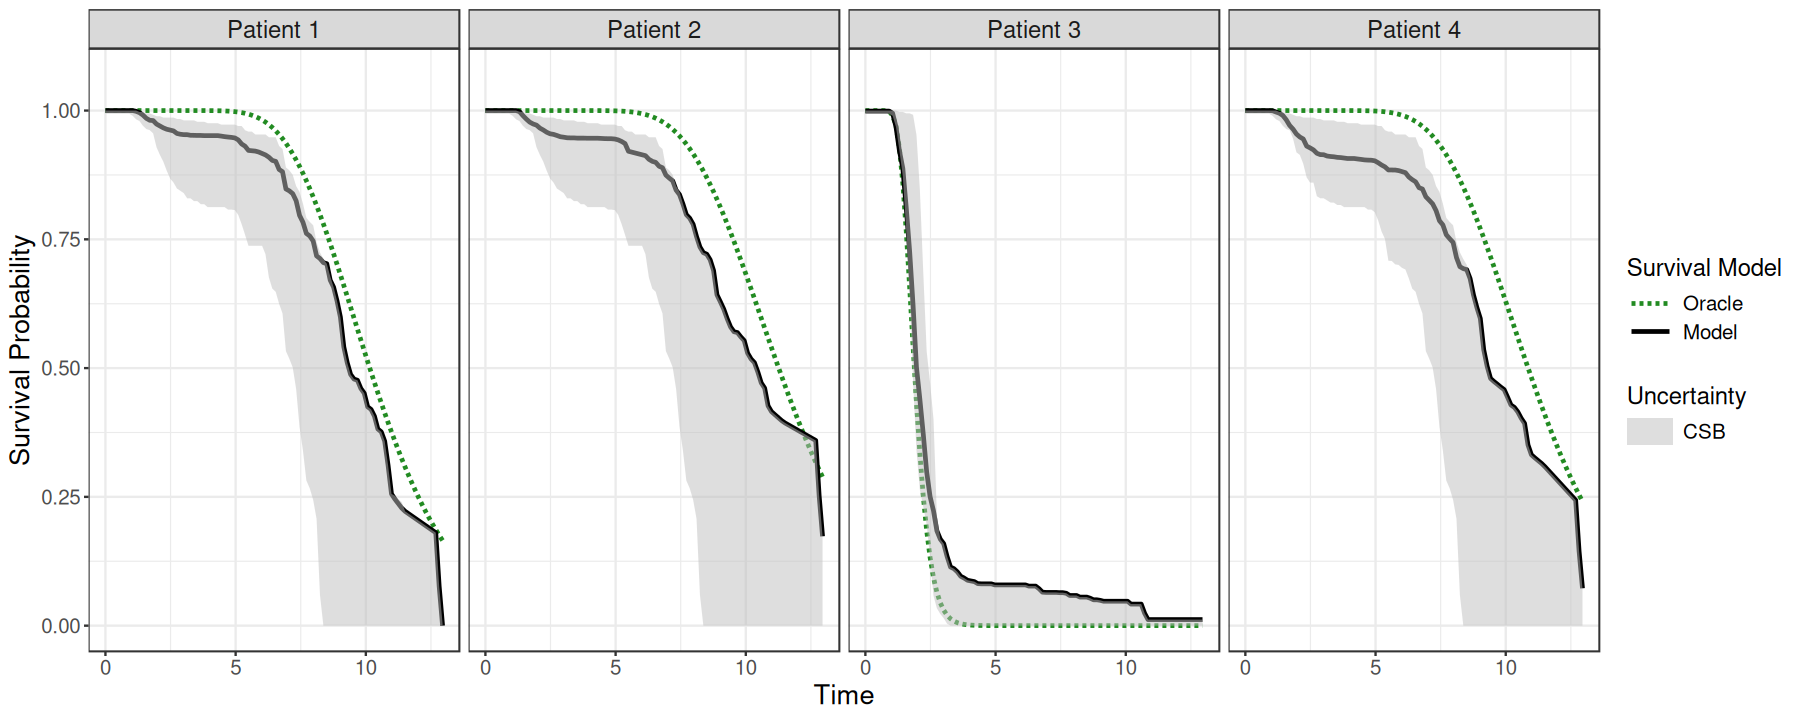

In [8]:
# Select patients to visualize
patient.list <- 1:12

# Adjust plot dimensions for wide layout
options(repr.plot.width = 15, repr.plot.height = 6)

# Extract time points from calibration results
time_points <- colnames(csb$model_pred)

# Compute true survival probabilities for test patients using the known generator
oracle_pred <- survival_generator$predict(data.test, as.numeric(time_points))$predictions
colnames(oracle_pred) <- time_points

# Adjust plot dimensions for wide layout
options(repr.plot.width = 15, repr.plot.height = 6)

# Select patients
patient_ids <- 1:4

# Subset prediction matrices
pred_list <- list(
  "Oracle" = oracle_pred[patient_ids, ],
  "Model" = csb$model_pred[patient_ids, ]
)

# Subset band matrices (same patients)
band_list <- list(
  "CSB" = list(
    lower = csb$lower[patient_ids, ],
    upper = csb$upper[patient_ids, ]
  )
)

# Now safe to plot
plot_survival_panel(
  pred_list = pred_list,
  band_list = band_list,
  patient_names = paste("Patient",patient_ids)
)

## Screening Analysis Using Conformal Survival Bands

We now demonstrate how to use the conformal survival bands to **screen patients** based on a clinical decision rule.

For example, suppose a practitioner wants to identify **low-risk patients**—those with at least an 80% chance of surviving beyond 5 months. The conformal bands allow this kind of decision to be made with **predictive guarantees**.

We will:
- Define a screening threshold
- Visualize band-based decisions for selected patients
- Compare selections made by:
  - The raw survival model (no uncertainty)
  - Conformal survival bands
  - The oracle survival curves (ground truth)


In [9]:
# Define screening parameters
screening_time <- 5           # Time threshold (e.g., 5 months)
screening_prob <- 0.8         # Survival probability threshold
screening_crit <- "low risk"  # Can also be "high risk"

# Display interpretation of the rule
cat(sprintf("Goal: Screening for %s.\n",
            interpret_screening_rule(screening_time, screening_prob, screening_crit)))

Goal: Screening for low-risk patients with P(survival at time 5.00) > 0.80.


### 📈 Visualize Screening Decisions for Individual Patients

We now visualize calibrated survival curves and screening selections using the `plot_survival_panel()` function. This plot compares multiple models and displays which patients are flagged under a chosen screening rule.

**Legend and Interpretation:**

- **Black line**: Fitted survival curve from the black-box model  
- **Gray shaded region**: Calibrated conformal survival band (doubly robust if enabled)  
- **Dashed green line**: Oracle (true) survival curve  
- **Vertical line**: Screening time (e.g., 5 months)  
- **Horizontal line**: Screening threshold (e.g., 80% survival)  
- **Markers above the curves**:
  - **Black circle**: Patient flagged by the uncalibrated model
  - **Red triangle**: Patient flagged by the conformal band
  - **Green asterisk**: Patient flagged by the oracle (truth)

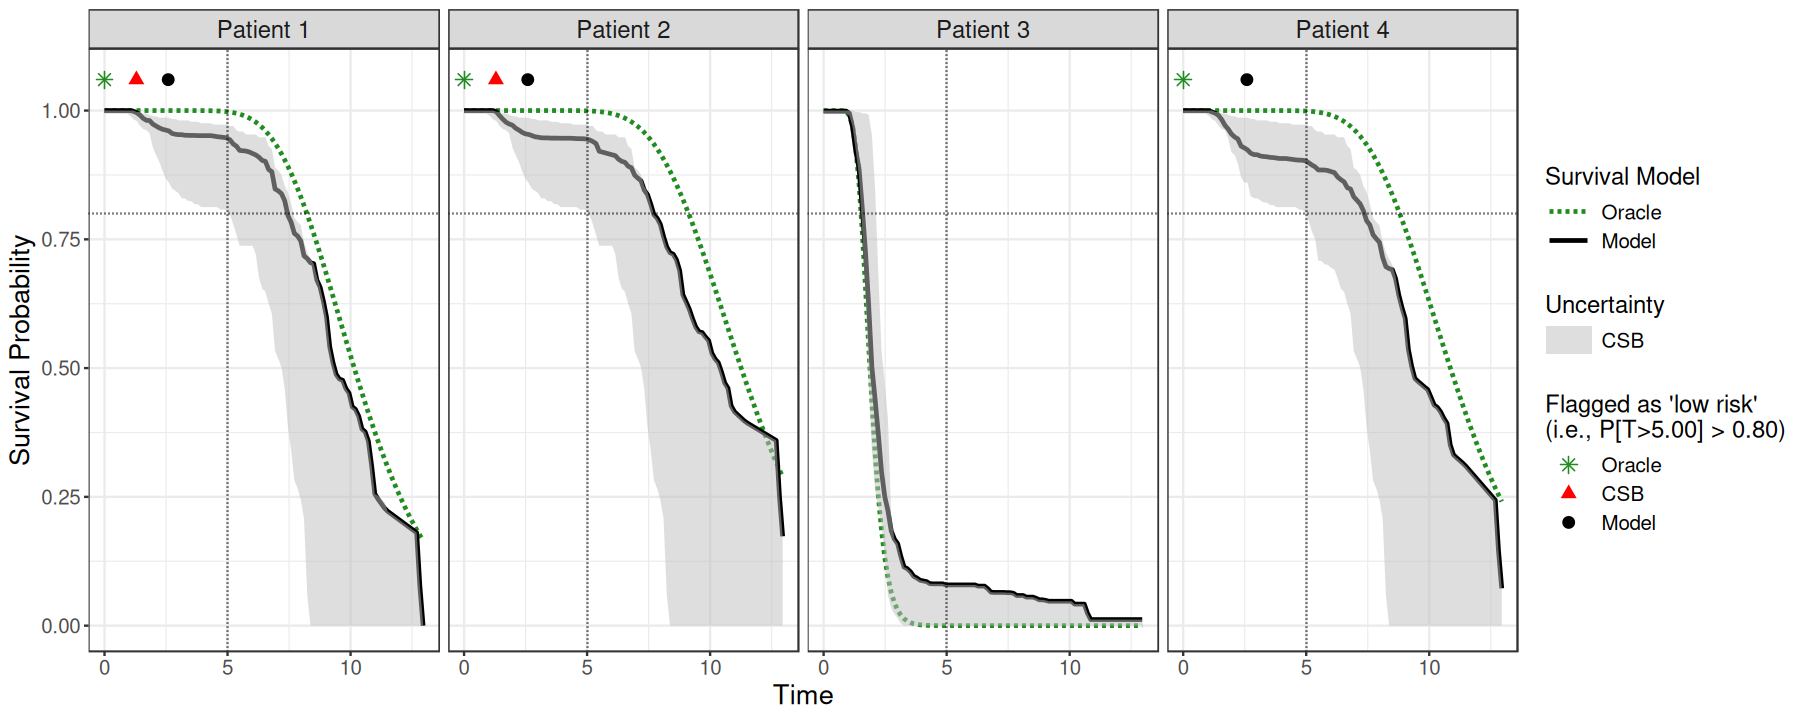

In [10]:
# Select patients
patient_ids <- 1:4

# Subset prediction matrices
pred_list <- list(
  "Oracle" = oracle_pred[patient_ids, ],
  "Model" = csb$model_pred[patient_ids, ]
)

# Subset band matrices (same patients)
band_list <- list(
  "CSB" = list(
    lower = csb$lower[patient_ids, ],
    upper = csb$upper[patient_ids, ]
  )
)

# Now safe to plot
plot_survival_panel(
  pred_list = pred_list,
  band_list = band_list,
  screening_time = screening_time,
  screening_prob = screening_prob,
  screening_crit = screening_crit,
  patient_names = paste("Patient",patient_ids)
)

### ✅ Evaluate Screening Accuracy Across Methods

We now compare different patient screening strategies under the defined decision rule:

- **Model**: Uses the raw point estimate from the black-box survival model
- **CSB**: Uses the calibrated conformal survival band
- **Oracle**: Uses the true (simulated) survival curves for reference

Each method is evaluated based on:
- How many patients it flags
- What fraction of flagged patients truly meet the risk threshold
- Whether it satisfies the desired predictive guarantee

In [11]:
# Extract calibration results
time.points <- as.numeric(colnames(csb$model_pred))
time.points.oracle <- as.numeric(colnames(oracle_pred))

# Apply the screening rule under different methods
sel_model      <- select_patients_point(time.points, csb$model_pred, screening_time, screening_prob, screening_crit)$selected
sel_conf       <- select_patients_band(time.points, csb$lower, csb$upper, screening_time, screening_prob, screening_crit)$selected
sel_oracle     <- select_patients_point(time.points.oracle, oracle_pred, screening_time, screening_prob, screening_crit)$selected

# Combine selections
selections <- list(
  "model"            = sel_model,
  "CSB"              = sel_conf,
  "oracle"           = sel_oracle
)

## Evaluate and format results
evaluated <- map2_dfr(selections, names(selections), function(selected, method_name) {           
    res.raw <- evaluate_selections(data.test.oracle, selected, screening_time, screening_prob, screening_crit)
    res.raw %>%
        mutate(
            Method = method_name
        ) %>%
        select(Method, everything())
})
evaluated

Method,Screening.time,Screening.rule,Screened,Proportion.survived,Valid
<chr>,<dbl>,<chr>,<int>,<dbl>,<lgl>
model,5,low-risk patients with P(survival at time 5.00) > 0.80,48,1,TRUE
CSB,5,low-risk patients with P(survival at time 5.00) > 0.80,37,1,TRUE
oracle,5,low-risk patients with P(survival at time 5.00) > 0.80,49,1,TRUE


In [12]:
# Extract calibration results
time.points <- as.numeric(colnames(csb$model_pred))
time.points.oracle <- as.numeric(colnames(oracle_pred))

# Apply the screening rule under different methods
sel_model      <- select_patients_point(time.points, csb$model_pred, screening_time, screening_prob, screening_crit)$selected
sel_conf       <- select_patients_band(time.points, csb$lower, csb$upper, screening_time, screening_prob, screening_crit)$selected
sel_oracle     <- select_patients_point(time.points.oracle, oracle_pred, screening_time, screening_prob, screening_crit)$selected

# Combine selections
selections <- list(
  "model"            = sel_model,
  "CSB"              = sel_conf,
  "oracle"           = sel_oracle
)

# Evaluate selections
evaluated <- map2_dfr(selections, names(selections), function(selected, method_name) {
  res.raw <- evaluate_selections(data.test.oracle, selected, screening_time, screening_prob, screening_crit)
  res.raw %>%
    as_tibble() %>%
    transmute(
      Method = method_name,
      Time = Screening.time,
      Criterion = screening_crit,
      Probability = screening_prob,
      Screened = Screened,
      Survival = Proportion.survived,
      Valid = Valid
    )
})

# Show the comparison table
evaluated

Method,Time,Criterion,Probability,Screened,Survival,Valid
<chr>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<lgl>
model,5,low risk,0.8,48,1,TRUE
CSB,5,low risk,0.8,37,1,TRUE
oracle,5,low risk,0.8,49,1,TRUE


## Using Custom Survival Models

The conformal survival band framework is designed to be **model-agnostic**, so long as the survival model exposes a consistent interface. To integrate a custom model, you need to wrap it in an `R6` class (or a plain list) that implements the following methods.

### Required Methods for a Wrapper Class

Each model should subclass the abstract `SurvivalModelWrapper` and implement:

- `fit(formula, data)`: Train the model using right-censored data
- `predict(new_data, time.points)`: Return a list with:
  - `predictions`: A matrix of survival probabilities (rows = patients, cols = time points)
  - `time.points`: Vector of time values corresponding to the columns

---

### 📦 Example: Custom Wrapper for KM Model

This example demonstrates how to integrate a simple Kaplan–Meier (KM) model into the conformal survival band framework using a plain R list.

Although KM is non-adaptive (it ignores covariates and gives the same survival curve for every individual), it still satisfies the required interface (`fit()` and `predict()` methods) and can be used to construct valid conformal bands — albeit without personalization.

In [13]:
# Minimal custom wrapper: KM model for all patients (no covariates, just baseline survival)
KMWrapper <- local({
  survfit_obj <- NULL
  default_time_points <- NULL

  list(
    fit = function(formula, data) {
      default_time_points <<- seq(min(data$time), max(data$time), length.out = 100)
      survfit_obj <<- survival::survfit(formula, data = data)
    },

    predict = function(new_data, time.points = NULL) {
      if (is.null(time.points)) {
        time.points <- default_time_points
      }

      # Evaluate the survival curve at the desired time points
      km_times <- survfit_obj$time
      km_surv <- survfit_obj$surv
      interp_fun <- stats::stepfun(km_times, c(1, km_surv), right = TRUE)

      # Return the same survival curve for all individuals
      surv_probs <- matrix(interp_fun(time.points),
                           nrow = nrow(new_data),
                           ncol = length(time.points),
                           byrow = TRUE)

      list(predictions = surv_probs, time.points = time.points)
    }
  )
})

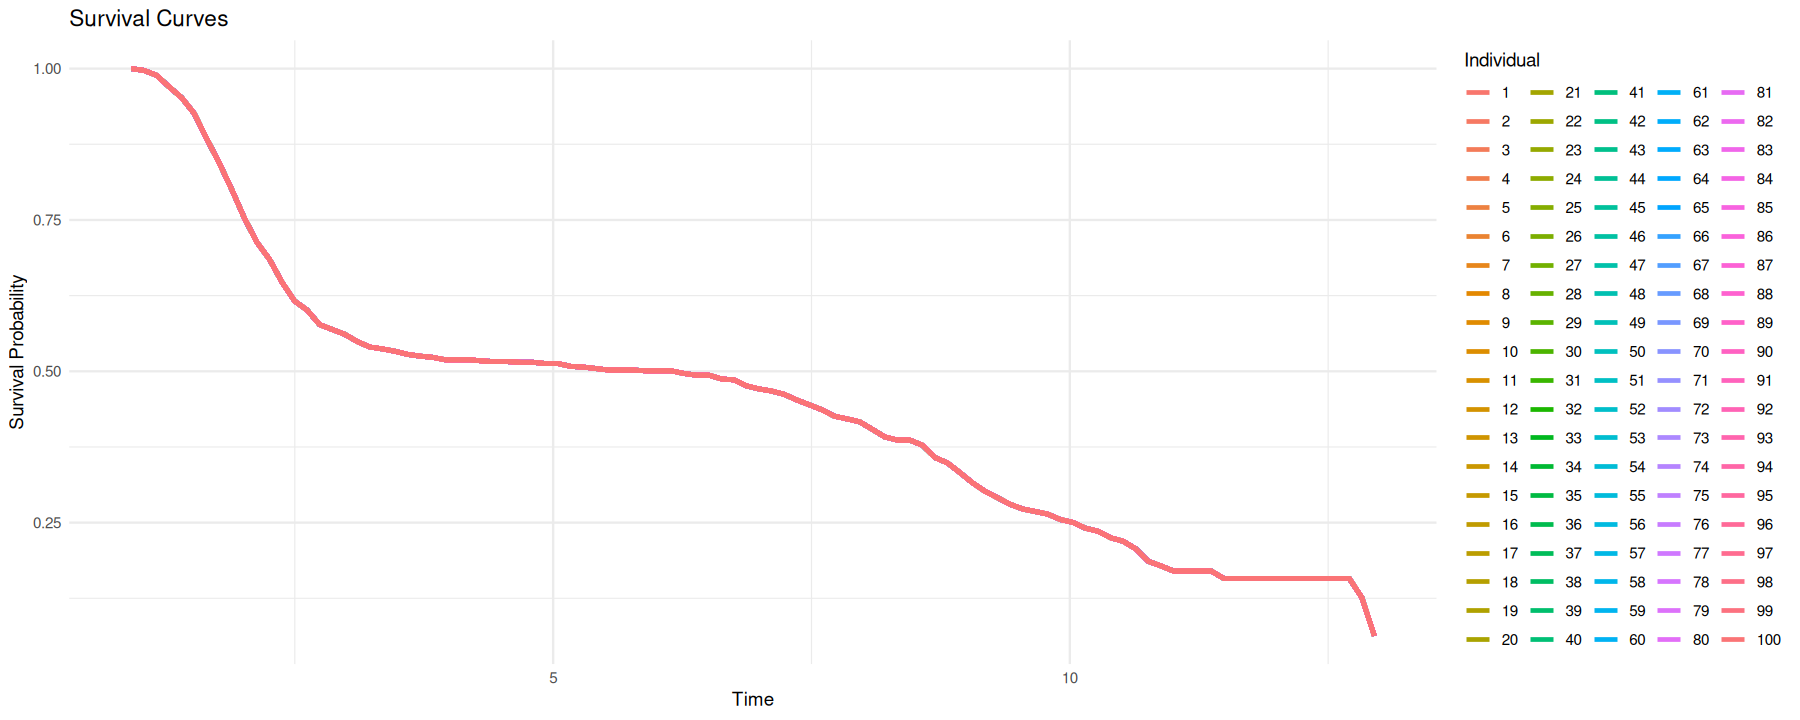

In [14]:
# Initialize model
km_model <- KMWrapper

# Fit using training data
km_model$fit(Surv(time, status) ~ 1, data = data.train)  # Note: no covariates

# Predict survival curves for test data
km_preds <- km_model$predict(data.test)

# Plot for all patients (they will all look the same)
plot_survival_curves(km_preds)

### Build Conformal Survival Bands Using a Custom (Non-Adaptive) Model

The Kaplan–Meier estimator is a non-adaptive model: it does **not use covariates** and produces the same survival curve for every patient. While it’s valid to use such models with conformal bands, they do not benefit from personalization — so all individuals will get identical predictions and bands.

Still, this provides a useful sanity check for CSB, and a minimal working example of the interface.

Below, we fit the KM wrapper, build conformal bands, and plot the results.


In [15]:
# Initialize Kaplan–Meier wrapper
km_model <- KMWrapper

# Fit to training data
km_model$fit(Surv(time, status) ~ 1, data = data.train)  # KM uses no covariates

# Fit censoring model (we still use GRF for IPC weights)
use.covariates <- paste0("X", 1:min(10, num_features))
cens_base_model <- init_censoring_model("grf", use_covariates = use.covariates)
cens_model <- CensoringModel$new(model = cens_base_model)
cens_model$fit(data = data.train)

time.points <- seq(0, max(data.train$time), length.out = 100)
csb_km <- conformal_survival_band(
    data.test = data.test,
    data.cal = data.cal,
    surv_model = km_model,
    cens_model = cens_model,
    time_points = time.points,
    fast = TRUE
)

### Visualize Kaplan–Meier Conformal Bands

Here we visualize the conformal bands produced by the KM model. Since the model is non-adaptive, every test patient receives **the same predicted curve and bands**.

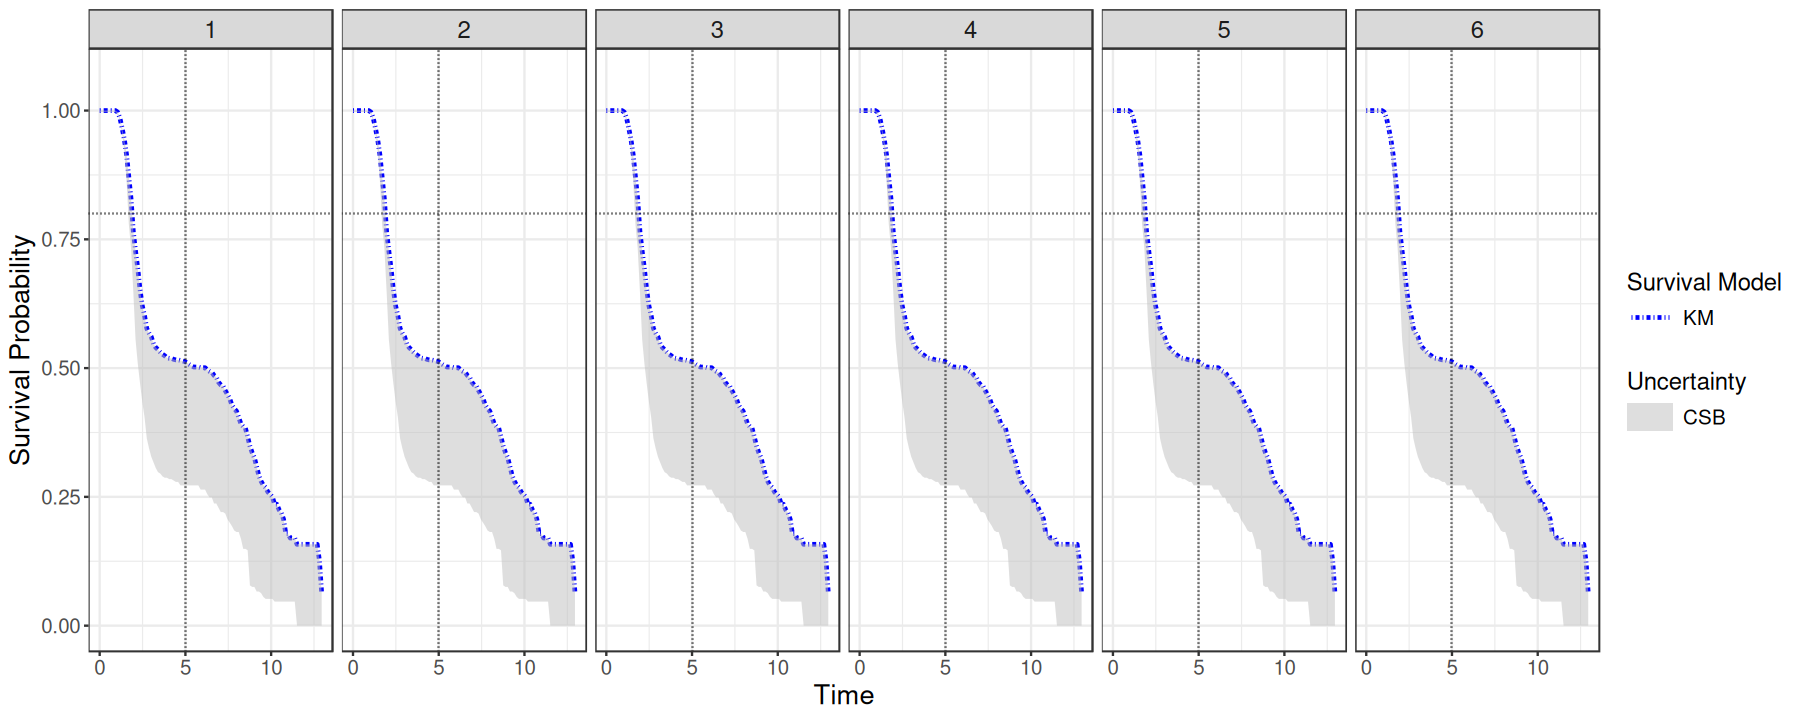

In [16]:
# Pick 6 patients to show identical predictions
patient_ids <- 1:6

pred_list <- list("KM" = csb_km$model_pred[patient_ids, ])
band_list <- list("CSB" = list(
    lower = csb_km$lower[patient_ids, ],
    upper = csb_km$upper[patient_ids, ]
))

plot_survival_panel(
  pred_list = pred_list,
  band_list = band_list,
  screening_time = 5,
  screening_prob = 0.8,
  screening_crit = "low risk",
  patient_names = patient_ids
)

## 🔁 Re-run Analysis with Covariate Shift (Setting 4)

Finally, we repeat the CSB construction and evaluation under **Setting 4**, which introduces a covariate shift between training and calibration/test distributions. This scenario simulates a form of model misspecification: even if the survival model fits the training distribution well, its predictions may no longer be reliable under shift

### 📊 Generate Shifted Data

In [17]:
# Setting 4 = new, more heterogeneous + shifted distribution
setting <- 4
datagen <- init_data_generator(setting)

generator <- SurvivalDataGenerator$new(datagen$covariate_generator,
                                       datagen$survival_generator,
                                       datagen$censoring_generator)
generator_shift <- SurvivalDataGenerator$new(datagen$covariate_generator,
                                             datagen$survival_generator_shift,
                                             datagen$censoring_generator)

# Sample sizes
num_samples_train <- 1000
num_samples_cal <- 500
num_samples_test <- 100

# Introduce distributional shift in training data
prop_shift <- 1

# Training data uses mixture distribution (shifting survival mechanism)
data.train.oracle <- sample_mixture(generator, generator_shift, num_samples_train, prop_shift = prop_shift)

# Calibration and test use original (non-shifted) generator
data.cal.oracle  <- generator$sample(num_samples_cal)
data.test.oracle <- generator$sample(num_samples_test)

# Remove true times (right-censoring)
data.train <- data.train.oracle |> select(-event_time, -censoring_time)
data.cal   <- data.cal.oracle   |> select(-event_time, -censoring_time)
data.test  <- data.test.oracle  |> select(-event_time, -censoring_time)

### 🧠 Fit Model and Censoring Estimator

In [18]:
# Initialize survival model
surv_model <- init_surv_model("grf")
surv_model$fit(Surv(time, status) ~ ., data = data.train)

# Fit censoring model
use.covariates <- paste0("X", 1:min(10, datagen$num_features))
cens_base_model <- init_censoring_model("grf", use_covariates = use.covariates)
cens_model <- CensoringModel$new(model = cens_base_model)
cens_model$fit(data = data.train)

### 📐 Build Conformal Survival Bands

In [19]:
# Calibrate bands under shifted model + clean calibration data
time.points <- seq(0, max(data.train$time), length.out = 100)

csb_shifted <- conformal_survival_band(
  data.test = data.test,
  data.cal = data.cal,
  surv_model = surv_model,
  cens_model = cens_model,
  time_points = time.points,
  fast = TRUE
)

### 📈 Visualize Shifted Predictions + Bands

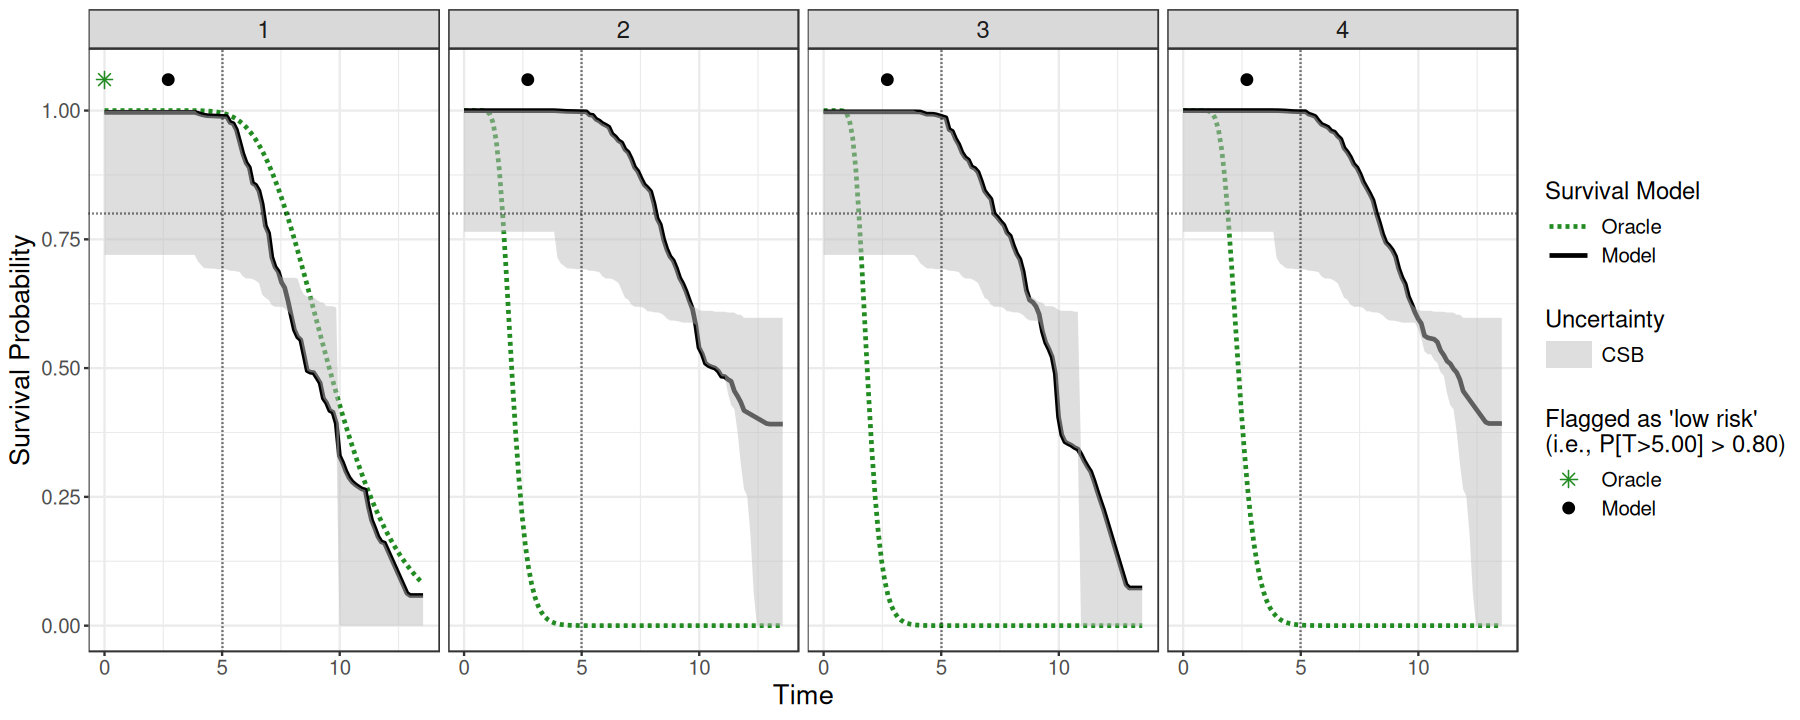

In [20]:
# Get oracle predictions (truth)
oracle_pred_shift <- datagen$survival_generator$predict(data.test, time.points)$predictions
colnames(oracle_pred_shift) <- time.points

# Subset patients for visualization
patient_ids <- 1:4
pred_list <- list("Model" = csb_shifted$model_pred[patient_ids, ],
                  "Oracle" = oracle_pred_shift[patient_ids, ])
band_list <- list("CSB" = list(
  lower = csb_shifted$lower[patient_ids, ],
  upper = csb_shifted$upper[patient_ids, ]
))

# Choose screening parameters
screening_time <- 5
screening_prob <- 0.8
screening_crit <- "low risk"

# Plot
plot_survival_panel(
  pred_list = pred_list,
  band_list = band_list,
  screening_time = screening_time,
  screening_prob = screening_prob,
  screening_crit = screening_crit,
  patient_names = patient_ids
)

### ✅ Evaluate Screening Performance

In [21]:
# Oracle truth
time.points.oracle <- as.numeric(colnames(oracle_pred_shift))

# Selections
sel_model  <- select_patients_point(time.points, csb_shifted$model_pred, screening_time, screening_prob, screening_crit)$selected
sel_conf   <- select_patients_band(time.points, csb_shifted$lower, csb_shifted$upper, screening_time, screening_prob, screening_crit)$selected
sel_oracle <- select_patients_point(time.points.oracle, oracle_pred_shift, screening_time, screening_prob, screening_crit)$selected

# Evaluate all
selections <- list(
  "model"            = sel_model,
  "CSB"        = sel_conf,
  "oracle"           = sel_oracle
)

evaluated_shifted <- map2_dfr(selections, names(selections), function(selected, method_name) {
  res.raw <- evaluate_selections(data.test.oracle, selected, screening_time, screening_prob, screening_crit)
  res.raw %>%
    as_tibble() %>%
    transmute(
      Method = method_name,
      Time = Screening.time,
      Criterion = screening_crit,
      Probability = screening_prob,
      Screened = Screened,
      Survival = Proportion.survived,
      Valid = Valid
    )
})

evaluated_shifted

Method,Time,Criterion,Probability,Screened,Survival,Valid
<chr>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<lgl>
model,5,low risk,0.8,100,0.5,FALSE
CSB,5,low risk,0.8,0,1.0,TRUE
oracle,5,low risk,0.8,50,1.0,TRUE
